In [3]:
import numpy as np
import pandas as pd
import warnings
from scipy.stats import chi2_contingency
from scipy import stats
from matplotlib import pyplot as plt
import json
import yapf.yapflib.yapf_api
from sklearn.utils import shuffle
warnings.filterwarnings("ignore")

1 Read the dataset 
========

In [4]:
data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt", sep=",")

In [5]:
# change field 38 to 3 groups
condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)

In [6]:
data["FIELD_6_7"] = np.min(
    data[["FIELD_6", "FIELD_7"]], axis=1
)  # combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)

data = data.drop(columns=["FIELD_6", "FIELD_7", "B_DAY"])
print(data.shape)

(535169, 405)


In [7]:
# add Class to the dataset
_class = []
for i in range(data.shape[0]):
    if((data.L102900[i] <= 200) & (data.L103200[i] <= 130) & (data.L103000[i] <=150)):
        _class.append(0)
    else:
        _class.append(1)
data["CLASS"] = _class

In [8]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia

data = data[data.FIELD_13 != 1]  
data = data[data.FIELD_20 != 1]  

print(data.shape)

(465879, 406)


In [9]:
# rename columns
data.rename(
    columns={
        "L104600": "HBA1C",
        "L103000": "Triglycerides",
        "L100800": "fasting glucose",
        "S000300": "BMI",
        "S000501": "SBP",
        "S000502": "DBP",
        "L101700": "r-GTP gamma",
        "L103300": "Cardiac risk factor",
        "L190400": "Hemoglobin",
        "L190500": "HCT",
        "L100700": "Uric Acid",
        "L101300": "SGPT",
        "L190300": "RBC",
        "L102900": "total cholesterol",
        "L103100": "HDL-Cholesterol",
    },
    inplace=True,
)

In [10]:
# split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith("FIELD")])
categorical_cols = list(data.columns[data.columns.str.startswith("FIELD")])
categorical_cols.append("CLASS")
numerical_cols.remove("SEX")
categorical_cols.append("SEX")

In [11]:
print(data.shape)
print(data.groupby(by='CLASS').size())

(465879, 406)
CLASS
0    224703
1    241176
dtype: int64


In [12]:
print(data.shape)
print(data.groupby(by='CLASS').size())

mydata=data.copy()
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

data = pd.concat([class1.sample(class0.shape[0],random_state=42), 
                  class0])

print(data.shape)

(465879, 406)
CLASS
0    224703
1    241176
dtype: int64
(449406, 406)


2 Feature Selection
===========

2.1 Calculate correlation Value - for numerical values
========

2.1.1 Pearson Correlation
======

In [11]:
corr = data[numerical_cols].corr()  # compute the correlation value
corr = corr.CLASS  # select the correlation values of the Class

# convert correlation values to dataframe
corrvalPD = pd.DataFrame()
corrvalPD["Col"] = corr.index
corrvalPD["val"] = abs(corr.values)

corrvalPD = corrvalPD.sort_values(by="val", ascending=False)
corrvalPD.head()

,Col,val
62,L120600,1.000000
274,CLASS,1.000000
147,L501600,1.000000
177,L518900,1.000000
155,L502600,0.999466


In [12]:
# get count of none NA values of each feature set
mydataset = data.copy()[numerical_cols]
colCount = []
for i in mydataset.columns:
    colCount.append([i, mydataset[i].dropna().shape[0]])

colCountPD = pd.DataFrame(colCount, columns=["Col", "Count"])
colCountPD.head()

,Col,Count
0,Unnamed: 0,449406
1,COMPARE,449406
2,AGE,449406
3,L100100,430371
4,L100200,430730


In [13]:
# merge the correlation value and the total count of the feature
mergedColCorrCount = pd.merge(
    corrvalPD, colCountPD, how="inner", left_on="Col", right_on="Col"
)
mergedColCorrCount = mergedColCorrCount[mergedColCorrCount.Count > 100000]
mergedColCorrCount = mergedColCorrCount.sort_values(by="val", ascending=False)
mergedColCorrCount.head(10)

,Col,val,Count
1,CLASS,1.000000,449406
7,total cholesterol,0.700596,448088
11,L103200,0.599450,447244
12,Cardiac risk factor,0.541234,382863
16,Triglycerides,0.418842,447929
28,BMI,0.272135,448186
31,Uric Acid,0.255052,431042
35,Hemoglobin,0.238498,448958
36,HCT,0.233037,447974
38,SBP,0.225502,449153


In [14]:
# select top 20 correlated features
print(list(mergedColCorrCount.head(16).Col))

['CLASS', 'total cholesterol', 'L103200', 'Cardiac risk factor', 'Triglycerides', 'BMI', 'Uric Acid', 'Hemoglobin', 'HCT', 'SBP', 'RBC', 'r-GTP gamma', 'DBP', 'AGE', 'fasting glucose', 'SGPT']


2.1.2 Anova test
=======

In [15]:
# another option for feature selection of numerical values

mydataset = data.copy()[numerical_cols]  # filter only numrical columns
colslist = mydataset.columns
DiabeticColVals = mydataset.CLASS

cor = []
pval = []
count = []

# for each column compute f and p values
for i in range(len(colslist)):

    temp = pd.DataFrame([])
    temp["a"] = DiabeticColVals
    temp["b"] = mydataset[colslist[i]]
    temp = temp.dropna()

    count.append(temp.shape[0])
    tempcor = temp.corr()

    if tempcor.shape[0] > 1:
        F, p = stats.f_oneway(
            temp[temp["a"] == 0].b, temp[temp["a"] == 1].b
        )
        cor.append(F)
        pval.append(p)
    else:
        cor.append(0)
        pval.append(0)

In [16]:
FvalPvalCorr = pd.DataFrame()
FvalPvalCorr["Cols"] = colslist
FvalPvalCorr["F"] = cor
FvalPvalCorr["P"] = pval
FvalPvalCorr["Count"] = count
FvalPvalCorr = FvalPvalCorr.sort_values(by="F", ascending=False)

In [17]:
# select top 20 features
print(list(FvalPvalCorr[FvalPvalCorr.Count > 100000].Cols)[:25])
FvalPvalCorr[FvalPvalCorr.Count > 100000].head(30)

['CLASS', 'total cholesterol', 'L103200', 'Cardiac risk factor', 'Triglycerides', 'BMI', 'Uric Acid', 'Hemoglobin', 'HCT', 'SBP', 'RBC', 'r-GTP gamma', 'DBP', 'AGE', 'fasting glucose', 'SGPT', 'L100500', 'L101600', 'L105200', 'L100100', 'L100200', 'HDL-Cholesterol', 'L100400', 'L190000', 'L101400']


,Cols,F,P,Count
274,CLASS,inf,0.0,449406
23,total cholesterol,4.319536e+05,0.0,448088
26,L103200,2.508536e+05,0.0,447244
27,Cardiac risk factor,1.586177e+05,0.0,382863
24,Triglycerides,9.529707e+04,0.0,447929
210,BMI,3.584608e+04,0.0,448186
8,Uric Acid,2.999063e+04,0.0,431042
91,Hemoglobin,2.707731e+04,0.0,448958
92,HCT,2.572479e+04,0.0,447974
212,SBP,2.406358e+04,0.0,449153


2.2 Correlation for categorical values
============

2.2.1 chi2 method
=====

In [13]:
# rename commen field names
categorical_cols[categorical_cols.index("FIELD_33")] = "_4_1_Smoking"
categorical_cols[categorical_cols.index("FIELD_38")] = "Drinking_5_1_days"
categorical_cols[
    categorical_cols.index("FIELD_40")
] = "_6_1_of_physical_activity_high_strength"
categorical_cols[categorical_cols.index("FIELD_31")] = "Family_history"
categorical_cols[
    categorical_cols.index("FIELD_41")
] = "_6_2_of_physical_activity_moderate"
categorical_cols[categorical_cols.index("FIELD_27")] = "_2_family_history_stroke"
categorical_cols[categorical_cols.index("FIELD_21")] = "_1_medication_heart_disease"
categorical_cols[categorical_cols.index("FIELD_14")] = "Whether_one_diagnosis_disease"
categorical_cols[categorical_cols.index("FIELD_32")] = "_3B_hepatitis"
categorical_cols[
    categorical_cols.index("FIELD_42")
] = "_6_3_of_physical_activity_walking"
categorical_cols[categorical_cols.index("FIELD_4")] = "blood_type"
categorical_cols[categorical_cols.index("FIELD_29")] = "_2_family_history_hypertension"
categorical_cols[categorical_cols.index("FIELD_3")] = "Blood_factor_RH_factor"
categorical_cols[categorical_cols.index("FIELD_19")] = "_1_drug_therapy_stroke"

In [14]:
mydata = data.rename(
    columns={
        "FIELD_33": "_4_1_Smoking",
        "FIELD_38": "Drinking_5_1_days",
        "FIELD_40": "_6_1_of_physical_activity_high_strength",
        "FIELD_31": "Family_history",
        "FIELD_41": "_6_2_of_physical_activity_moderate",
        "FIELD_27": "_2_family_history_stroke",
        "FIELD_21": "_1_medication_heart_disease",
        "FIELD_14": "Whether_one_diagnosis_disease",
        "FIELD_32": "_3B_hepatitis",
        "FIELD_42": "_6_3_of_physical_activity_walking",
        "FIELD_4": "blood_type",
        "FIELD_29": "_2_family_history_hypertension",
        "FIELD_3": "Blood_factor_RH_factor",
        "FIELD_19": "_1_drug_therapy_stroke",
    },
    inplace=True,
)


# mydata=data[categorical_cols] # filter only categorical columns

In [15]:
# filter only categorical columns
mydata = data[categorical_cols]
# remove columns with string values as data type
mydata = mydata.drop(
    columns=[
        "FIELD_1",
        "FIELD_2",
        "FIELD_8",
        "FIELD_10",
        "FIELD_11",
        "FIELD_12",
        "FIELD_39",
        "FIELD_88",
        "FIELD_89",
        "FIELD_109",
        "FIELD_110",
        "FIELD_111",
        "FIELD_70",
        "FIELD_82",
        "FIELD_85",
        "FIELD_91",
        "FIELD_103",
        "FIELD_106",
    ]
)

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_38_C,FIELD_6_7,CLASS,SEX
83441,NaN,2,2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1,1.0
514070,NaN,2,3,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0
294689,1,2,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1,1.0
9226,NaN,1,2,NaN,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0.0
248539,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0


In [16]:
# Data clean up
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "`"]
    .dropna()
    .index
)
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "G"]
    .dropna()
    .index
)

mydata = mydata.drop(
    mydata[["blood_type"]][mydata[["blood_type"]] == "."].dropna().index
)
mydata = mydata.drop(mydata[mydata.FIELD_5 == "."].index)


mydata = mydata.drop(mydata[mydata.FIELD_35 == "?"].index)
mydata = mydata.drop(mydata[mydata.FIELD_35 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_36 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_37 == "\\"].index)
mydata.head()

# mydata=mydata.drop(mydata[mydata.FIELD_39 == '7+' ].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '5~7'].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '3-4'].index)


mydata = mydata.drop(mydata[mydata.FIELD_95 == "."].index)
mydata.head()

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_38_C,FIELD_6_7,CLASS,SEX
83441,NaN,2,2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1,1.0
514070,NaN,2,3,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0
294689,1,2,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1,1.0
9226,NaN,1,2,NaN,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1,0.0
248539,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,0.0


In [22]:
AllTables = []

# prepare the table indicating the number of entries per class and per each column group
for j in range(len(mydata.columns)):

    columnName = mydata.columns[j]
    print(j, columnName)

    temp = mydata[columnName].dropna().astype(float).unique()
    mytempdata = mydata[[columnName, "CLASS"]].dropna()
    mytempdata[columnName] = mytempdata[columnName].astype(float)
    temptable = []

    sumval = 0

    for i in range(temp.shape[0]):

        temp_i_val = str(temp[i])
        class0_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 0"
        ).shape[0]
        class1_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 1"
        ).shape[0]

        sumval = sumval + (class0_count + class1_count)

        temptable.append([class0_count, class1_count])

    #     print(sumval,mytempdata.shape[0], mytempdata.shape[0] == sumval)

    if len(temptable) > 1:
        AllTables.append([temptable, columnName, mytempdata.shape[0]])

0 Blood_factor_RH_factor
1 blood_type
2 FIELD_5
3 FIELD_9
4 FIELD_13
5 Whether_one_diagnosis_disease
6 FIELD_15
7 FIELD_16
8 FIELD_17
9 FIELD_18
10 _1_drug_therapy_stroke
11 FIELD_20
12 _1_medication_heart_disease
13 FIELD_22
14 FIELD_23
15 FIELD_24
16 FIELD_25
17 FIELD_26
18 _2_family_history_stroke
19 FIELD_28
20 _2_family_history_hypertension
21 FIELD_30
22 Family_history
23 _3B_hepatitis
24 _4_1_Smoking
25 FIELD_34
26 FIELD_35
27 FIELD_36
28 FIELD_37
29 Drinking_5_1_days
30 _6_1_of_physical_activity_high_strength
31 _6_2_of_physical_activity_moderate
32 _6_3_of_physical_activity_walking
33 FIELD_43
34 FIELD_44
35 FIELD_45
36 FIELD_46
37 FIELD_47
38 FIELD_48
39 FIELD_49
40 FIELD_50
41 FIELD_51
42 FIELD_52
43 FIELD_53
44 FIELD_54
45 FIELD_55
46 FIELD_56
47 FIELD_57
48 FIELD_58
49 FIELD_59
50 FIELD_60
51 FIELD_61
52 FIELD_62
53 FIELD_63
54 FIELD_64
55 FIELD_65
56 FIELD_66
57 FIELD_67
58 FIELD_68
59 FIELD_69
60 FIELD_72
61 FIELD_73
62 FIELD_74
63 FIELD_75
64 FIELD_76
65 FIELD_77
66 FIE

In [23]:
# compute the statisitical values
statas = []
for i in range(len(AllTables)):
    #     print(i,AllTables[i][1])
    table = AllTables[i][0]
    stat, p, dof, expected = chi2_contingency(table)
    statas.append(
        [
            AllTables[i][1],
            stat,
            p,
            dof,
            np.sum(table),
            AllTables[i][2],
            AllTables[i][1],
            table,
            expected,
        ]
    )

In [25]:
# convert the computed status to dataframe
finalstat = pd.DataFrame(
    statas,
    columns=[
        "Name",
        "stat",
        "p",
        "dof",
        "instances",
        "orginal",
        "Name2",
        "table",
        "expected",
    ],
)
finalstat = finalstat[
    finalstat.orginal > 100000
]  # select columns with count at least 200, 000

# sort stat value and select top 20 features
finalstat.stat = finalstat.stat.astype(int)
finalstat = finalstat.sort_values(by="stat", ascending=False)

print(list(finalstat.Name[:16]))
finalstat[["Name", "stat", "instances"]].head(10)

['CLASS', 'SEX', 'FIELD_6_7', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', 'blood_type', '_6_1_of_physical_activity_high_strength', '_2_family_history_stroke', '_6_2_of_physical_activity_moderate', 'FIELD_5', 'FIELD_28', '_6_3_of_physical_activity_walking', 'Family_history', '_1_medication_heart_disease', '_3B_hepatitis']


,Name,stat,instances
103,CLASS,449388,449392
104,SEX,17337,449392
102,FIELD_6_7,12756,198411
17,_4_1_Smoking,11575,447216
22,Drinking_5_1_days,2758,417950
101,FIELD_38_C,1481,417950
1,blood_type,678,439008
23,_6_1_of_physical_activity_high_strength,675,418012
11,_2_family_history_stroke,520,446172
24,_6_2_of_physical_activity_moderate,309,417933


3 Refine the selected numerical and categorical features
====

In [ ]:
data.shape

In [26]:
# combine the selected columns list from section 2.1.2 and 2.2.1

newColList = [
    'BMI', 'Uric Acid', 
    'Hemoglobin', 'HCT', 'SBP', 'RBC', 'r-GTP gamma', 'DBP', 'AGE', 'fasting glucose', 'SGPT', 
    'L100500', 'max', 'L101600', 'L105200', 'L100100', 'L100200', 'L100400', 
    'L190000',
    'SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', #'blood_type', 'HDL-Cholesterol', 'Cardiac risk factor', 
    '_6_1_of_physical_activity_high_strength', '_2_family_history_stroke', '_6_2_of_physical_activity_moderate', 
    'FIELD_5', 'FIELD_28', '_6_3_of_physical_activity_walking', 'Family_history', '_1_medication_heart_disease', 
    '_3B_hepatitis',
    "CLASS",
]

In [27]:
# filter a new data based on the selected columns
mydata = data[newColList].copy().dropna()


# mydata = mydata.drop(
#     mydata[["blood_type"]][mydata[["blood_type"]] == "."].dropna().index
# )
mydata = mydata.drop(mydata[mydata.FIELD_5 == "."].index)

print(mydata.shape)
mydata.head()


(54510, 33)


,BMI,Uric Acid,Hemoglobin,HCT,SBP,RBC,r-GTP gamma,DBP,AGE,fasting glucose,...,_6_1_of_physical_activity_high_strength,_2_family_history_stroke,_6_2_of_physical_activity_moderate,FIELD_5,FIELD_28,_6_3_of_physical_activity_walking,Family_history,_1_medication_heart_disease,_3B_hepatitis,CLASS
83441,22.0,5.5,14.5,44.8,109.0,4.82,30.0,72.0,44.0,102.0,...,2.0,0.0,2.0,2,0.0,2.0,0.0,0.0,2.0,1
294689,21.6,5.2,13.1,38.6,131.0,4.60,16.0,80.0,31.0,83.0,...,2.0,0.0,2.0,1,0.0,1.0,0.0,0.0,2.0,1
142525,23.4,4.8,14.1,44.2,107.0,4.79,18.0,73.0,31.0,108.0,...,2.0,0.0,0.0,2,0.0,2.0,1.0,0.0,3.0,1
84120,21.0,4.7,13.4,39.8,134.0,4.40,17.0,82.0,30.0,76.0,...,3.0,0.0,3.0,1,0.0,3.0,0.0,0.0,3.0,1
123641,22.4,4.1,12.5,38.6,106.0,3.98,15.0,68.0,28.0,81.0,...,2.0,0.0,2.0,2,0.0,7.0,0.0,0.0,2.0,1


In [28]:
x = mydata[
    [
    'BMI', 'Uric Acid', 
    'Hemoglobin', 'HCT', 'SBP', 'RBC', 'r-GTP gamma', 'DBP', 'AGE', 'fasting glucose', 'SGPT', 
    'L100500', 'max', 'L101600', 'L105200', 'L100100', 'L100200', 'L100400', 
    'L190000','SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', #'blood_type', 'HDL-Cholesterol', 'Cardiac risk factor', 
    '_6_1_of_physical_activity_high_strength', '_2_family_history_stroke', '_6_2_of_physical_activity_moderate', 
    'FIELD_5', 'FIELD_28', '_6_3_of_physical_activity_walking', 'Family_history', '_1_medication_heart_disease', 
    '_3B_hepatitis'
    ]
]


y = mydata[["CLASS"]]

print(x.shape)
mydata.head()

(54510, 32)


,BMI,Uric Acid,Hemoglobin,HCT,SBP,RBC,r-GTP gamma,DBP,AGE,fasting glucose,...,_6_1_of_physical_activity_high_strength,_2_family_history_stroke,_6_2_of_physical_activity_moderate,FIELD_5,FIELD_28,_6_3_of_physical_activity_walking,Family_history,_1_medication_heart_disease,_3B_hepatitis,CLASS
83441,22.0,5.5,14.5,44.8,109.0,4.82,30.0,72.0,44.0,102.0,...,2.0,0.0,2.0,2,0.0,2.0,0.0,0.0,2.0,1
294689,21.6,5.2,13.1,38.6,131.0,4.60,16.0,80.0,31.0,83.0,...,2.0,0.0,2.0,1,0.0,1.0,0.0,0.0,2.0,1
142525,23.4,4.8,14.1,44.2,107.0,4.79,18.0,73.0,31.0,108.0,...,2.0,0.0,0.0,2,0.0,2.0,1.0,0.0,3.0,1
84120,21.0,4.7,13.4,39.8,134.0,4.40,17.0,82.0,30.0,76.0,...,3.0,0.0,3.0,1,0.0,3.0,0.0,0.0,3.0,1
123641,22.4,4.1,12.5,38.6,106.0,3.98,15.0,68.0,28.0,81.0,...,2.0,0.0,2.0,2,0.0,7.0,0.0,0.0,2.0,1


3.1 ExtraTreesClassifier feature_importances method
========================

[0.05040924 0.04608789 0.03776642 0.03846904 0.0433737  0.03851889
 0.03930744 0.0405975  0.06626824 0.04286704 0.04195652 0.02529206
 0.03370496 0.03920117 0.0382538  0.05012897 0.03872308 0.03904664
 0.03964813 0.         0.0100404  0.01808429 0.0146124  0.02644004
 0.00772357 0.0294978  0.0239264  0.00861488 0.03371753 0.01268852
 0.0007872  0.02424623]


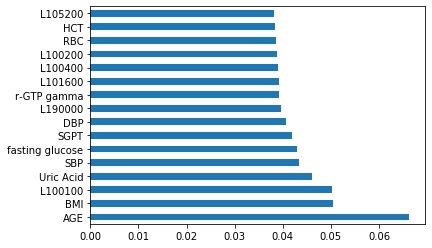

Index(['AGE', 'BMI', 'L100100', 'Uric Acid', 'SBP', 'fasting glucose', 'SGPT',
       'DBP', 'L190000', 'r-GTP gamma', 'L101600', 'L100400', 'L100200', 'RBC',
       'HCT', 'L105200', 'Hemoglobin'],
      dtype='object')


In [29]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(x, y)

print(
    model.feature_importances_
)  # use inbuilt class feature_importances of tree based classifiers

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(17).index)

3.2 SelectKBest method
=========

In [30]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]  # naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:20]))

['BMI', 'Uric Acid', 'Hemoglobin', 'HCT', 'SBP', 'RBC', 'r-GTP gamma', 'DBP', 'AGE', 'fasting glucose', 'SGPT', 'L100500', 'max', 'L101600', 'L105200', 'L100100', 'L100200', 'L100400', 'L190000', 'SEX']


3.3 variance inflation factor 
=============

In [31]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance


def vifcal(inputdata, depcol):
    vifL5 = []
    import statsmodels.formula.api as sm

    xvars = inputdata.drop([depcol], axis=1)
    xvarnames = xvars.columns
    for i in range(0, xvarnames.shape[0]):
        _y = xvars[xvarnames[i]]
        _x = xvars[xvarnames.drop(xvarnames[i])]
        rsq = sm.ols(formula="_y~_x", data=xvars).fit().rsquared
        vif = round(1 / (1 - rsq), 2)
        print(i, ", ", xvarnames[i], " VIF = ", vif)
        if vif < 5:
            vifL5.append(xvarnames[i])
    return vifL5

In [32]:
# the new columns are selcted from section 3.2
# newcols = vifcal(mydata[['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX',
#                          'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100',
#                          'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31','CLASS']],'CLASS')

newcols = vifcal(
    mydata[
        [
            'AGE', 'L100100', #'DBP','SBP', 'HDL-Cholesterol', 
       'Uric Acid', 'BMI', 'L100200', 'r-GTP gamma', 'fasting glucose',
       'L101600', 'L100400', 'SGPT', 'RBC', 'Hemoglobin', 'HCT',
        '_4_1_Smoking','SEX','Drinking_5_1_days', '_6_1_of_physical_activity_high_strength',
            "CLASS",
        ]
    ],
    "CLASS",
)
print(newcols, len(newcols))

# we need to exclude features with vif value >5
# L190400  ,L103300,L190500,L190300,L102900,L103100

0 ,  AGE  VIF =  1.42
1 ,  L100100  VIF =  1.82
2 ,  Uric Acid  VIF =  1.21
3 ,  BMI  VIF =  1.27
4 ,  L100200  VIF =  1.92
5 ,  r-GTP gamma  VIF =  1.32
6 ,  fasting glucose  VIF =  1.14
7 ,  L101600  VIF =  1.33
8 ,  L100400  VIF =  1.18
9 ,  SGPT  VIF =  1.25
10 ,  RBC  VIF =  2.47
11 ,  Hemoglobin  VIF =  8.52
12 ,  HCT  VIF =  11.57
13 ,  _4_1_Smoking  VIF =  1.06
14 ,  SEX  VIF =  0.0
15 ,  Drinking_5_1_days  VIF =  1.14
16 ,  _6_1_of_physical_activity_high_strength  VIF =  1.03
['AGE', 'L100100', 'Uric Acid', 'BMI', 'L100200', 'r-GTP gamma', 'fasting glucose', 'L101600', 'L100400', 'SGPT', 'RBC', '_4_1_Smoking', 'SEX', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength'] 15


3.4 Final Selected Features
======

In [17]:
# based on the out put of section of 3.2 and 3.3 the following features are selected


# finalFeatures = [
# #     'Cardiac risk factor', 'HDL-Cholesterol', 
#     'AGE', 'L100100', 'BMI',
#        'max', 'SBP', 'Uric Acid', 'L100200', 'r-GTP gamma', 'DBP', 'L105200',
#        'L100400', 'SGPT', 'fasting glucose', 'HCT', 'RBC',
#     'CLASS'
# ]



# finalFeatures = ['HDL-Cholesterol', 'AGE', 'L100100', #'DBP','SBP', 
#        'Uric Acid', 'BMI', 'L100200', 'r-GTP gamma', 'fasting glucose',
#        'L101600', 'L100400', 'SGPT', 'RBC', 'Hemoglobin', 'HCT',
#         '_4_1_Smoking','SEX','Drinking_5_1_days', '_6_1_of_physical_activity_high_strength',
#     'CLASS'
# ]



# finalFeatures = ['AGE',  'Uric Acid', 'BMI',  'r-GTP gamma', 
#                  'fasting glucose',  '_4_1_Smoking', 'SEX', 'Drinking_5_1_days', 
#                  '_6_1_of_physical_activity_high_strength',
#                  #'L100100','L100200','L101600', 'L100400', 'SGPT','HDL-Cholesterol', 
#     'CLASS'
# ]



finalFeatures = ['AGE', 'BMI', 'Uric Acid', 'fasting glucose','L100100','SBP','DBP','L100200','SGPT', 
                 'L190000','L100400','r-GTP gamma', 'RBC', 'HCT','Hemoglobin', 'L101600', 'L105200', 
                 'CLASS'
]



# finalFeatures = ['AGE','SEX', 'BMI', 'Uric Acid', 'fasting glucose', 'SGPT',#'SBP','DBP',,'L100100','L190000','L100200',
#                  'L100400','r-GTP gamma', 'RBC', 'HCT','Hemoglobin', 'L101600', #'L105200', 
# #                  '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength',
#                  'CLASS'
# ]



# # for the company request
# finalFeatures = ['AGE','SEX', 'Uric Acid', 'BMI','r-GTP gamma', 'fasting glucose', 
#                  'SGPT',   'RBC', 'HCT',
# #                  'L101600','L100400', 'Hemoglobin', 
#                  '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength',
#                  'CLASS'
# ]






# finalFeatures=['HBA1C', 'Triglycerides', 'BMI',  'r-GTP gamma', 'SEX', 'AGE', 'Uric Acid',
#                '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength', 'Family_history','CLASS']

Classifier Model Test Based on the features 
========

In [18]:
randomseed = 7
mydata = data[finalFeatures].copy().dropna()
print(mydata.shape)
mydata.head()

(410718, 18)


,AGE,BMI,Uric Acid,fasting glucose,L100100,SBP,DBP,L100200,SGPT,L190000,L100400,r-GTP gamma,RBC,HCT,Hemoglobin,L101600,L105200,CLASS
83441,44.0,22.0,5.5,102.0,7.7,109.0,72.0,4.9,25.0,7.47,15.1,30.0,4.82,44.8,14.5,88.0,51.0,1
514070,45.0,25.1,5.4,111.0,7.1,118.0,68.0,4.2,49.0,7.34,14.5,62.0,5.37,49.8,17.1,46.0,85.0,1
294689,31.0,21.6,5.2,83.0,7.2,131.0,80.0,4.5,10.0,6.07,11.3,16.0,4.60,38.6,13.1,49.0,103.0,1
9226,48.0,28.3,8.8,95.0,7.3,115.0,75.0,4.7,67.0,6.26,21.5,39.0,5.49,48.3,16.7,69.0,62.0,1
248539,57.0,24.5,6.9,102.0,7.2,117.0,60.0,4.5,16.0,6.73,20.4,31.0,5.54,49.4,16.5,72.0,73.0,1


In [19]:
mydata.columns

Index(['AGE', 'BMI', 'Uric Acid', 'fasting glucose', 'L100100', 'SBP', 'DBP',
       'L100200', 'SGPT', 'L190000', 'L100400', 'r-GTP gamma', 'RBC', 'HCT',
       'Hemoglobin', 'L101600', 'L105200', 'CLASS'],
      dtype='object')

In [20]:
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

print(class1.shape[0],class0.shape[0],)

class1_test = class1.sample(10000, random_state=randomseed)
class0_test = class0.sample(10000, random_state=randomseed)
test = pd.concat([class1_test, class0_test])
test=shuffle(test)


class1_train = class1.drop(class1_test.index) #.sample( class2_train.shape[0], random_state=randomseed)
class0_train = class0.drop(class0_test.index) #.sample( class2_train.shape[0], random_state=randomseed)
train = pd.concat([class1_train, class0_train])
train=shuffle(train)

204455 206263


In [21]:
train.to_csv('train.txt',sep=',')
test.to_csv('test.txt',sep=',')

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
train.iloc[:, :-1]=scaler.fit_transform(train.iloc[:, :-1])
test.iloc[:, :-1]=scaler.transform(test.iloc[:, :-1])

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=randomseed, n_estimators=100, max_depth=10)
rf.fit(train.iloc[:, :-1], train.iloc[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.7017


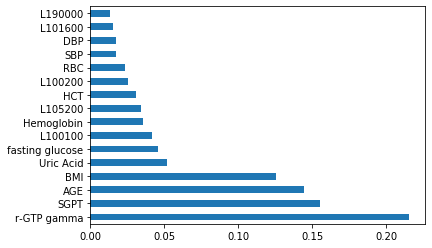

Index(['r-GTP gamma', 'SGPT', 'AGE', 'BMI', 'Uric Acid', 'fasting glucose',
       'L100100', 'Hemoglobin', 'L105200', 'HCT', 'L100200', 'RBC', 'SBP',
       'DBP', 'L101600', 'L190000'],
      dtype='object')
r-GTP gamma        0.215485
SGPT               0.154936
AGE                0.144096
BMI                0.125582
Uric Acid          0.051925
fasting glucose    0.045754
L100100            0.041936
Hemoglobin         0.035929
L105200            0.034425
HCT                0.030767
L100200            0.025144
RBC                0.023275
SBP                0.017582
DBP                0.017370
L101600            0.015318
L190000            0.013310
dtype: float64
0.9928324070254859


In [24]:
ypred = rf.predict(test.iloc[:, :-1])

score = rf.score(test.iloc[:, :-1], test.iloc[:, -1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)
print(feat_importances.nlargest(16))

print(np.sum(feat_importances.nlargest(16)))

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test.iloc[:, -1], ypred)

array([[6962, 3038],
       [2928, 7072]], dtype=int64)

In [26]:
print(
    "Accuracy on training set: {:.3f}".format(
        rf.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
ypred = rf.predict(test.iloc[:, :-1])

confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], ypred))
confmatrx.head()

Accuracy on training set: 0.713
Accuracy on test set: 0.702


,0,1
0,6962,3038
1,2928,7072


In [27]:
from sklearn.metrics import classification_report

print(classification_report(test.iloc[:, -1], ypred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70     10000
           1       0.70      0.71      0.70     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000



In [28]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

xgb_model.fit(train.iloc[:, :-1], train.iloc[:, -1])

y_pred = xgb_model.predict((test.iloc[:, :-1]))

print(
    "Accuracy on training set: {:.3f}".format(
        xgb_model.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(xgb_model.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
confmatrx.head()

Accuracy on training set: 0.699
Accuracy on test set: 0.703


,0,1
0,6981,3019
1,2915,7085


In [29]:
print(classification_report(test.iloc[:, -1], y_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.70     10000
           1       0.70      0.71      0.70     10000

    accuracy                           0.70     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.70      0.70      0.70     20000



===============================
==========

In [34]:
# import pickle

# with open('HyperlipidemiaClassifierModel', 'wb') as f:
#     pickle.dump(rf, f)

In [181]:
# train.to_csv('train.txt',sep=',')
# test.to_csv('test.txt',sep=',')